# Improving classification with the AdaBoost meta-algorithm

$\epsilon = \frac{number of incorrectly classified examples}{total number of examples}$

$\alpha = \frac{1}{2}\ln (\frac{1-\epsilon}{\epsilon})$

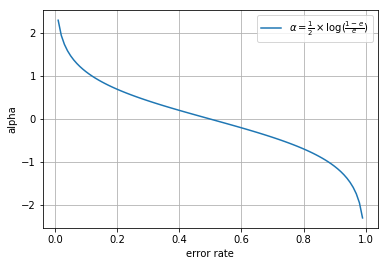

In [141]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

e = np.arange(0.01,1,0.01)
alpha = 1/2*np.log((1-e)/e)
plt.figure()
plt.plot(e,alpha,label='$\\alpha =\\frac{1}{2}\\times\\log(\\frac{1-e}{e})$')
plt.xlabel('error rate')
plt.ylabel('alpha')
plt.grid()
plt.legend()
plt.show()

if correctly predicted:
$$D_i^{(t+1)} = \frac{D_i^{(t)}e^{-\alpha}}{Sum(D)}$$
if incorrectly predicted:
$$D_i^{(t+1)} = \frac{D_i^{(t)}e^{\alpha}}{Sum(D)}$$

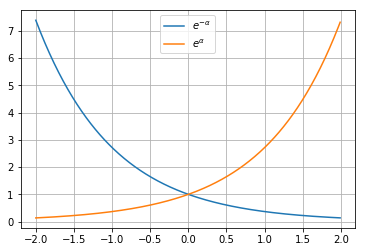

In [140]:
alpha = np.arange(-2,+2,0.01)
plt.figure()
plt.plot(alpha, np.exp(-alpha),label='$e^{-\\alpha}$')
plt.plot(alpha, np.exp(alpha),label='$e^{\\alpha}$')
plt.legend()
plt.grid()
plt.show()

In [142]:
import numpy as np
def loadSimData():
    datMat = np.matrix([
        [1.,2.1],
        [2.,1.1],
        [1.3,1.],
        [1.,1.],
        [2.,1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

[1.  2.  1.3 1.  2. ]


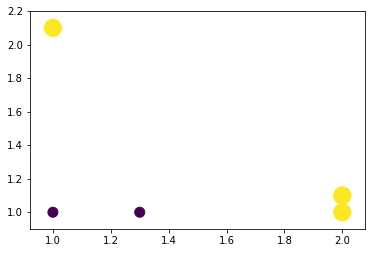

In [143]:
%matplotlib inline
import matplotlib.pyplot as plt

dataMat,classLabels = loadSimData()
print(dataMat[:,0].flatten().getA()[0])
fig=plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dataMat[:,0].flatten().getA()[0],dataMat[:,1].flatten().getA()[0],(np.array(classLabels)+2)*100,(np.array(classLabels)+2)*50)
plt.show()

In [144]:
# perform a threshold comarison to classify data
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    # set the return array to all 1s
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt': # less than
        # set elements meet comparison to -1
        retArray[dataMatrix[:,dimen]<=threshVal] = -1.0
    else: # greater than
        retArray[dataMatrix[:,dimen]>threshVal] = -1.0
    return retArray

In [145]:
# 根据输入的概率向量D，返回误差最小的划分方式
def buildStump(dataArr, classLabels, D):
    # 转化为matrix类型
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix) # 获取数据集的行列数
    numSteps = 10.0 # 搜索的步骤
    bestStump = {} # to store the classifier information
    bestClassEst = np.mat(np.zeros((m,1))) # vector D
    minError = np.inf
    # 遍历数据集中的每一个特征
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin)/numSteps
        # 对当前特征的每一个数值进行遍历
        for j in range(-1, int(numSteps)+1):
            # 对大于和小于等于两种情况进行遍历
            for inequal in ['lt', 'gt']: 
                #得到阈值
                threshVal = rangeMin + float(j)*stepSize
                #按照当前的配置参数，得到相应的预测值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals==labelMat]=0 #正确分类的数据误差设置为0
                weightedError = D.T*errArr # 得到相应的权重乘以误差的和
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" \
                #      %(i,threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClassEst  = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClassEst

In [146]:
dataMat,classLabels = loadSimData()
D = np.mat(np.ones((5,1))/5)
bestStump, minError, bestClassEst = buildStump(dataMat, classLabels, D)
print("bestStump:",bestStump)
print("minError:",minError)
print("bestClassEst:",bestClassEst)

bestStump: {'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}
minError: [[0.2]]
bestClassEst: [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


In [147]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    # contain the decision stumps
    weakClassArr = [] 
    # the number of data points
    m = np.shape(dataArr)[0] 
    # create weight D,also probability distribution
    # initialize every element to 1/m
    D = np.mat(np.ones((m,1))/m)
    # aggregate estimate 预估的标签
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        # get best feature to split
        bestStump, error, classEst = buildStump(dataArr,classLabels,D)
        print("D:",D.T)
        # alpha calculation
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))
        # add to dictionary
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print("classEst:", classEst.T)
        # to calculate new weights D for the next iteration
        expon = np.multiply(-1*alpha*np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon)) # 更新参数D
        D = D/D.sum()
        # #累加类别估计值, 累加多个弱分类器得到最终结果
        aggClassEst += alpha*classEst
        print("aggClassEst", aggClassEst.T)
        # get the total error rate
        aggErrors = np.multiply(np.sign(aggClassEst)!=np.mat(classLabels).T, np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error:", errorRate)
        if errorRate==0.0:
            break;
    return weakClassArr

In [125]:
weakClassArr = adaBoostTrainDS(dataMat,classLabels,9) # iteration times = 9
print("weakClassArr", weakClassArr)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst: [[-1.  1. -1. -1.  1.]]
aggClassEst [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error: 0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst: [[ 1.  1. -1. -1. -1.]]
aggClassEst [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error: 0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst: [[1. 1. 1. 1. 1.]]
aggClassEst [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error: 0.0
weakClassArr [{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]


## Test: classifying with AdaBoost

In [153]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],\
                                classifierArr[i]['thresh'],\
                                classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst
        print(aggClassEst)
    return np.sign(aggClassEst)

In [156]:
datArr,labelArr=loadSimData()
classifierArr = adaBoostTrainDS(datArr,labelArr,30)
print('result is :',adaClassify([0, 0],classifierArr))

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst: [[-1.  1. -1. -1.  1.]]
aggClassEst [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error: 0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst: [[ 1.  1. -1. -1. -1.]]
aggClassEst [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error: 0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst: [[1. 1. 1. 1. 1.]]
aggClassEst [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error: 0.0
[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]
[[-1.]]


In [158]:
print('results is:',adaClassify([[5, 5],[0,0]],classifierArr))

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]
results is: [[ 1.]
 [-1.]]


## Example: AdaBoost on a difficult dataset